# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import gc
import pandas as pd

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


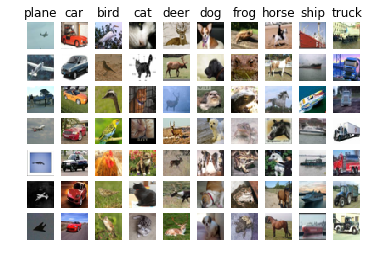

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
gc.collect()

15

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000 # number of tests?
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape) 
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


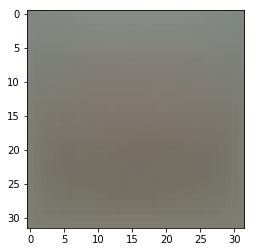

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)

print(mean_image[:10]) # print a few of the elements

plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
gc.collect()

2283

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [ ]:
W.shape, X_dev.shape, y_dev.shape

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_naive_new
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss = svm_loss_naive_new(W, X_dev, y_dev, 0.000005)
print('loss: {}'.format(loss[0]))

loss: 8.896393454954662


In [11]:
#implement fucntion for testing reasons 

loss_my = svm_loss_naive_new(W, X_dev, y_dev, 0.000005)
#assert len(loss_my) == 4500 # test the working model 
loss_my

(8.896393454954662,
 array([[-2.04184458e+01, -5.37778335e+00, -1.99070367e+00, ...,
          4.28913518e+00, -6.71797314e+00, -3.39903366e+01],
        [-2.87263288e+01,  2.98268490e+00, -7.71077551e-01, ...,
          1.23785388e+00, -1.76714886e+01, -4.71036896e+01],
        [-4.20194695e+01,  8.80412212e+00,  1.08061731e+01, ...,
          4.67379135e+00, -3.51752697e+01, -6.49142685e+01],
        ...,
        [-3.11448473e+00,  3.12061060e-01, -5.98991347e+00, ...,
         -1.04211043e+01,  2.53998651e+01, -1.31138842e+01],
        [-1.15108077e+01, -4.43323086e+00, -7.41931429e-01, ...,
          1.15571966e+01,  6.87281200e+00, -2.38552866e+01],
        [-1.80000002e-02, -7.19999997e-02,  1.60000001e-01, ...,
         -8.00000006e-03,  2.79999997e-02, -2.01999999e-01]]))

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive_new(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive_new(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive_new(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive_new(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -1.324705 analytic: -1.324705, relative error: 1.395958e-10
numerical: -3.057929 analytic: -3.057929, relative error: 7.991728e-11
numerical: 2.521829 analytic: 2.535594, relative error: 2.721685e-03
numerical: 0.564216 analytic: 0.564216, relative error: 5.270551e-11
numerical: 23.842155 analytic: 23.842155, relative error: 2.130974e-11
numerical: 12.895912 analytic: 12.845104, relative error: 1.973813e-03
numerical: -5.047322 analytic: -5.047322, relative error: 2.471792e-11
numerical: 20.005809 analytic: 20.005809, relative error: 3.032568e-11
numerical: 22.767975 analytic: 22.719946, relative error: 1.055860e-03
numerical: -1.330529 analytic: -1.330529, relative error: 4.441472e-11
numerical: -0.128064 analytic: -0.158869, relative error: 1.073572e-01
numerical: -3.625986 analytic: -3.625986, relative error: 3.852476e-11
numerical: 2.333087 analytic: 2.333087, relative error: 1.478486e-10
numerical: -4.947030 analytic: -4.947030, relative error: 6.235524e-12
numerical: -

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

1. I suppose the function is not differentiable at some point (like 0)
2. If the values of the X would inside [-1, 1]
3. Normailze the data?

In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive_new(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized_new
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized_new(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.896393e+00 computed in 0.243765s
Vectorized loss: 8.896393e+00 computed in 0.008101s
difference: 0.000000


In [ ]:
# Example of using Boolean for selecting the arrays

D = np.array([True, False, True, False])
S = np.array([2,6,3,2])

S[D]

In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()

_, grad_naive = svm_loss_naive_new(W, X_dev, y_dev, 0.000005)

toc = time.time()

print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()

_, grad_vectorized = svm_loss_vectorized_new(W, X_dev, y_dev, 0.000005)

toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.202217s
Vectorized loss and gradient: computed in 0.007324s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM

svm = LinearSVM()

tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()

print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 779.380623
iteration 100 / 1500: loss 469.943682
iteration 200 / 1500: loss 285.894556
iteration 300 / 1500: loss 175.768658
iteration 400 / 1500: loss 109.407354
iteration 500 / 1500: loss 69.392467
iteration 600 / 1500: loss 45.711724
iteration 700 / 1500: loss 31.572178
iteration 800 / 1500: loss 22.296290
iteration 900 / 1500: loss 17.525885
iteration 1000 / 1500: loss 13.821059
iteration 1100 / 1500: loss 12.318759
iteration 1200 / 1500: loss 10.733990
iteration 1300 / 1500: loss 10.083740
iteration 1400 / 1500: loss 9.482969
That took 7.531526s


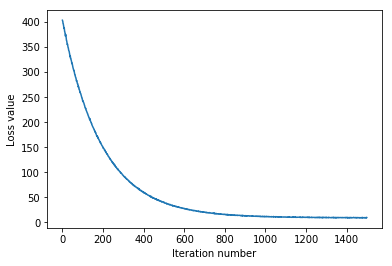

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)

print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.080796
validation accuracy: 0.088000


In [17]:
# generate the list of the small float numbers with defined step
def float_range(x, y, step):
    while x < y:
        yield x
        x += step

# setup the needed range for tuning paraments 
        
range_f = list(float_range(1e-7, 5e-5, 0.000001)) # learning rates 
range_g = list(float_range(2.5e4, 5.5e4, 5000)) # regularization_strenghts 

In [18]:
# set up new instatnce 
svm_test = LinearSVM()

In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

my_results = {}

learning_rate = []
regularization = []

# two loops cycle 

for r in range_g:
    for l in range_f:
        
        loss_val_t = svm_test.train(X_train, y_train, learning_rate=l, reg=r)
        
        acc_score_t = np.mean(svm_test.predict(X_val) == y_val)
        
        acc_score_s = np.mean(svm_test.predict(X_train) == y_train)
        
        learning_rate.append(l)
        
        regularization.append(r)
        
        my_results[(r,l)] = (acc_score_t, acc_score_s)
        
        if acc_score_t > acc_score_s:
            best_val = acc_score_t
            best_svm = svm_test
        
#print('Best learning rate : {}, \
#best acc score:{}, best reg rate:{}'.format(learning_rate[np.argmax(acc_score_s)], \
                                                                     #np.max(acc_score_s), \
                                                                     #regularization[np.argmax(acc_score_s)]))


In [20]:
# Print out results.
for lr, reg in sorted(my_results):
    train_accuracy, val_accuracy = my_results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.500000e+04 reg 1.000000e-07 train accuracy: 0.109000 val accuracy: 0.101612
lr 2.500000e+04 reg 1.100000e-06 train accuracy: 0.076000 val accuracy: 0.074020
lr 2.500000e+04 reg 2.100000e-06 train accuracy: 0.108000 val accuracy: 0.103898
lr 2.500000e+04 reg 3.100000e-06 train accuracy: 0.126000 val accuracy: 0.118878
lr 2.500000e+04 reg 4.100000e-06 train accuracy: 0.144000 val accuracy: 0.132612
lr 2.500000e+04 reg 5.100000e-06 train accuracy: 0.079000 val accuracy: 0.085939
lr 2.500000e+04 reg 6.100000e-06 train accuracy: 0.124000 val accuracy: 0.141918
lr 2.500000e+04 reg 7.100000e-06 train accuracy: 0.050000 val accuracy: 0.049673
lr 2.500000e+04 reg 8.100000e-06 train accuracy: 0.082000 val accuracy: 0.095061
lr 2.500000e+04 reg 9.100000e-06 train accuracy: 0.061000 val accuracy: 0.068429
lr 2.500000e+04 reg 1.010000e-05 train accuracy: 0.117000 val accuracy: 0.106143
lr 2.500000e+04 reg 1.110000e-05 train accuracy: 0.087000 val accuracy: 0.092653
lr 2.500000e+04 reg 1.210000

Text(0.5, 1.0, 'CIFAR-10 training accuracy')

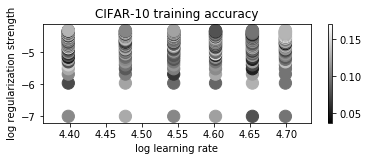

In [21]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in my_results]
y_scatter = [math.log10(x[1]) for x in my_results]

# plot training accuracy
marker_size = 150
colors = [my_results[x][0] for x in my_results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')


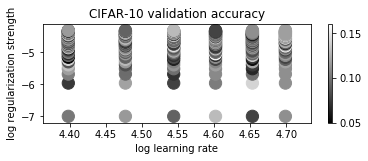

In [22]:

# plot validation accuracy
colors = [my_results[x][1] for x in my_results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [23]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.140000


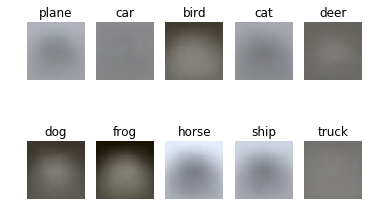

In [24]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *they have commonon patern that can be 'recognized' but the comp. pattern can invlude - shapes, edges, colors, lines etc/ 